In [1]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt



In [2]:


# Charger le csv
df = pd.read_csv("../vessel-total-clean-final.csv")

# Convertir la colonne date en datetime
df['base_date_time'] = pd.to_datetime(df['base_date_time'])

# Trier par mmsi + date (si plusieurs navires)
df = df.sort_values(['mmsi', 'base_date_time'])

# Calculer delta_seconds pour chaque MMSI

# Pour chaque MMSI, faire état actuel + état suivant
df['lat_next'] = df.groupby('mmsi')['lat'].shift(-1)
df['lon_next'] = df.groupby('mmsi')['lon'].shift(-1)
df['delta_seconds'] = df.groupby('mmsi')['base_date_time'].diff().shift(-1).dt.total_seconds()

# Enlever lignes sans target ou delta
df = df.dropna(subset=['lat_next', 'lon_next', 'delta_seconds'])

print(df[['lat', 'lon', 'lat_next', 'lon_next', 'delta_seconds']].head())

print(df.head)





             lat       lon  lat_next  lon_next  delta_seconds
110941  25.95847 -97.37876  25.95846 -97.37880          360.0
111259  25.95846 -97.37880  25.95847 -97.37880          180.0
111462  25.95847 -97.37880  25.95848 -97.37879          900.0
117554  25.95848 -97.37879  25.95846 -97.37882          180.0
113165  25.95846 -97.37882  25.95848 -97.37882          180.0
<bound method NDFrame.head of               id       mmsi      base_date_time       lat       lon  sog  cog  \
110941   9067786  205776000 2023-05-25 00:07:27  25.95847 -97.37876  0.0  0.0   
111259   9094320  205776000 2023-05-25 00:13:27  25.95846 -97.37880  0.0  0.0   
111462   9113012  205776000 2023-05-25 00:16:27  25.95847 -97.37880  0.0  0.0   
117554   9625845  205776000 2023-05-25 00:31:27  25.95848 -97.37879  0.0  0.0   
113165   9261545  205776000 2023-05-25 00:34:27  25.95846 -97.37882  0.0  0.0   
...          ...        ...                 ...       ...       ...  ...  ...   
374075  34248908  671830000 202

Creation des labels y

In [3]:
features = ['lat', 'lon', 'sog', 'cog', 'heading', 'length', 'draft', 'delta_seconds']
X = df[features]
y = df[['lat_next', 'lon_next']]

Estimation du meilleur modele

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

In [5]:
# Définir la grille d'hyperparamètres
param_grid = param_grid = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

# Créer le modèle de base
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', LinearRegression())
])

# Créer le GridSearch avec cross-validation (ici cv=3 folds)
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Lancer la recherche
grid_search.fit(X_train, y_train)

# Afficher le meilleur modèle et ses paramètres
print("✅ Meilleurs hyperparamètres :")
print(grid_search.best_params_)

print("✅ Score CV (MSE négatif) :", grid_search.best_score_)

# Extraire le meilleur modèle
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.3s
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.4s
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.4s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.4s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.4s
[CV] END ...model__fit_intercept=False, model__positive=True; total time=   0.4s
[CV] END ...model__fit_intercept=False, model__positive=True; total time=   0.5s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.4s
[CV] END ..model__fit_intercept=False, model__positive=False; total time=   0.3s
[CV] END ...model__fit_intercept=False, model__positive=True; total time=   0.3s
[CV] END ..model__fit_intercept=False, model__positive=False; total time=   0.3s
[CV] END ..model__fit_intercept=False, model__pos

In [6]:
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', LinearRegression())
])
model = best_model
#[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 2.2min
#✅ Meilleurs hyperparamètres :
#{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
#✅ Score CV (MSE négatif) : -0.002453481436743822
# Entraîner le modèle sur l'ensemble d'entraînement
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)
model.fit(X_train, y_train)

,steps,"[('imputer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,fit_intercept,False


In [7]:
y_pred = model.predict(X_test)
print("y_test shape :", y_test.shape)
print("y_pred shape :", y_pred.shape)

y_test shape : (76618, 2)
y_pred shape : (76618, 2)


In [8]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Statistiques de performance :")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

Statistiques de performance :
RMSE : 0.0669
MAE  : 0.0031
R²   : 0.9992


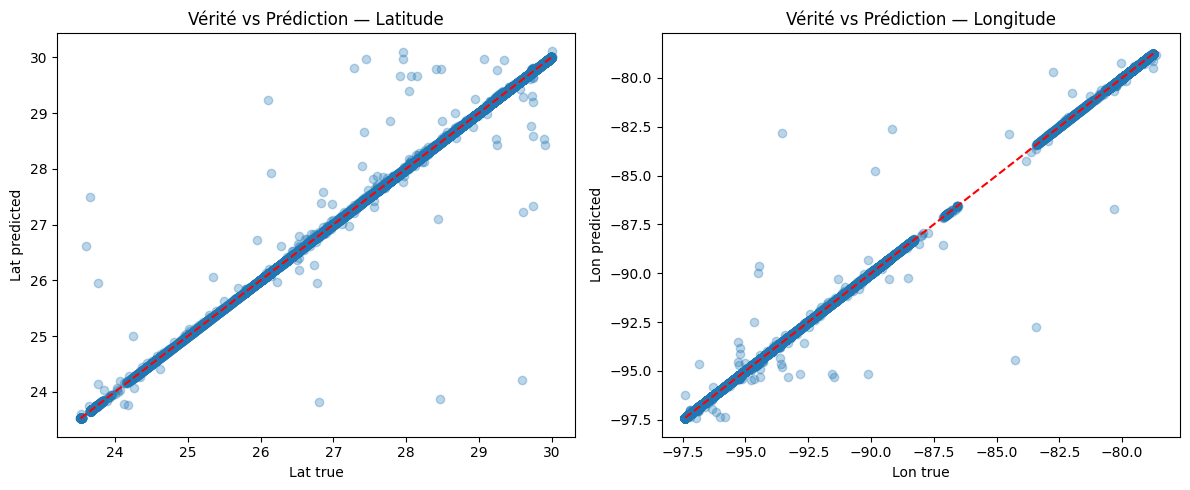

In [9]:
plt.figure(figsize=(12,5))

# Pour latitude
plt.subplot(1,2,1)
plt.scatter(y_test.iloc[:,0], y_pred[:,0], alpha=0.3)
plt.plot([y_test.iloc[:,0].min(), y_test.iloc[:,0].max()],
         [y_test.iloc[:,0].min(), y_test.iloc[:,0].max()],
         'r--')
plt.title("Vérité vs Prédiction — Latitude")
plt.xlabel("Lat true")
plt.ylabel("Lat predicted")

# Pour longitude
plt.subplot(1,2,2)
plt.scatter(y_test.iloc[:,1], y_pred[:,1], alpha=0.3)
plt.plot([y_test.iloc[:,1].min(), y_test.iloc[:,1].max()],
         [y_test.iloc[:,1].min(), y_test.iloc[:,1].max()],
         'r--')
plt.title("Vérité vs Prédiction — Longitude")
plt.xlabel("Lon true")
plt.ylabel("Lon predicted")

plt.tight_layout()
plt.show()

In [10]:
joblib.dump(model, "trajectoire.pkl")

['trajectoire.pkl']

In [11]:

# Reconstruire df_all avec toutes les paires (état, delta_seconds, cible)
df_all = df.dropna(subset=['lat_next', 'lon_next', 'delta_seconds']).copy()


# Même jeu de features que pour l'entraînement
features = ['lat', 'lon', 'sog', 'cog', 'heading', 'length', 'draft', 'delta_seconds']
X_all = df_all[features]
y_all = df_all[['lat_next', 'lon_next']]

# Définir les intervalles
mask_small  = df_all['delta_seconds'] < 300
mask_medium = df_all['delta_seconds'].between(300, 1200)
mask_large  = df_all['delta_seconds'] > 1200

print("🔍 RMSE par intervalle de delta_seconds :")
for name, mask in [
    ('small (<5min)', mask_small),
    ('medium (5–20min)', mask_medium),
    ('large (>20min)', mask_large)
]:
    X_sub = X_all[mask]
    y_sub = y_all[mask]
    if X_sub.empty:
        print(f"{name} : aucun échantillon")
        continue
    y_pred = model.predict(X_sub)
    rmse = root_mean_squared_error(y_sub, y_pred)
    print(f"{name} RMSE = {rmse:.4f}")

🔍 RMSE par intervalle de delta_seconds :
small (<5min) RMSE = 0.0019
medium (5–20min) RMSE = 0.0105
large (>20min) RMSE = 0.9056
